# Homework12

Exercises with Neural Networks

## Goals

- Get familiar with neural network setup, design, data preparation and training process
- Practice setting up the ingredients and parameters for the training loop
- Experiment with neural networks for classification tasks


### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/nn_utils.py
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/lfw.tar.gz | tar xz

In [2]:
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from torch import nn, Tensor

from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from nn_utils import get_labels

## Neural Networks and Classification

We saw a neural network that performs linear regression in the [WK12](https://github.com/PSAM-5020-2025S-A/WK12) notebook, but, how can we use one for classification ?

The modifications aren't too hard. We first need to have as many output nodes as we have classes in our dataset. If we're trying to classify images into $25$ categories, we need $25$ output neurons.

We also need to use a different kind of loss/cost function that will force the network to only have one activated neuron in its output layer, per input. If we give it data for something that should be classified as class $7$, the neuron that represents class $7$ at the output layer should be activated way more than the others.

### Cross Entropy Loss

The cost of being wrong for a classification network is calculated using a function called *Cross Entropy*. It basically measures how different two distributions are, and in this case, we want to compare the distributions of values from the last layer of our network and what we expected to get at the last layer, over all of the inputs that it was shown.

For example, let's say we are training a classification neural network on a dataset with $3$ classes. The correct distribution of labels in the training dataset is:

| $\text{class}$ | $\text{distribution}$ |
|----|----|
| $0$ | $45\%$ |
| $1$ | $35\%$ |
| $2$ | $20\%$ |

but instead we get the following distribution for the predictions:

| $\text{class}$ | $\text{distribution}$ |
|----|----|
| $0$ | $32\%$ |
| $1$ | $32\%$ |
| $2$ | $36\%$ |

*Cross Entropy* is a way to quantify how different these two distributions are and, hopefully, guide our network parameters to make them more similar.

The actual cost calculation is a sum of how different each prediction is from a "perfect" prediction. For example, if we're trying to classify something as class $0$, we should get output neuron activations that are something like: `[1.0, 0.0, 0.0]`. If instead we get: `[0.5, 0.8, 0.1]`, the *Cross Entropy* contribution for this sample is calculated as:
$$\displaystyle - \log\left(\frac{e^{0.5}}{e^{0.5} + e^{0.8} + e^{0.1}}\right)$$

By using this as the cost function, the neural network can optimize its parameters to increase the value of the first output, while decreasing the values of the other outputs. It doesn't have to get `[1.0, 0.0, 0.0]` exactly, so the network optimizes its parameters to make the first output as different as possible from the others.

Instead of writing our own cost function like we did with the euclidean cost for linear regression, we'll use the built in `CrossEntropyLoss` function in the `PyTorch` library.

### The Process ...

... is the same.

### Start with the Data

As always, we start with the data, and this time put the pixel and label information straight into `Tensor` objects.

In [3]:
train, test = LFWUtils.train_test_split(0.5)

x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

len(x_train), len(x_test), len(y_train), len(y_test)

(445, 438, 445, 438)

#### notes
Sigmoid
Range: Outputs values between 0 and 1.
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

Advantages:
Useful for binary classification problems (e.g., logistic regression).
Outputs can be interpreted as probabilities.

Disadvantages:
Vanishing Gradient Problem: Gradients become very small for large positive or negative inputs, slowing down learning.
Not Zero-Centered: Outputs are always positive, which can lead to inefficient weight updates during backpropagation.

ReLU (Rectified Linear Unit)
Range: Outputs values between 0 and infinity for positive inputs, and 0 for negative inputs.
$$ f(x) = \max(0, x) $$

Advantages:
Efficient Computation: Simple and computationally efficient.
No Vanishing Gradient: Gradients do not saturate for positive inputs, allowing faster convergence.
Works well in deep networks.

Disadvantages:
Dying ReLU Problem: Neurons can "die" during training if they output 0 for all inputs, leading to no gradient updates.


Sigmoid:
Use in the output layer for binary classification tasks.
Rarely used in hidden layers due to vanishing gradient issues.

ReLU:
Use in hidden layers for most deep learning tasks.
Works well for classification and regression problems.

### Let's train !

Let's create a single layer neural network, like the one from class, and train it with the training data.

In addition to the actual model/network, we also need an optimizer and a loss function.

In [4]:
# Get the actual number of classes
num_classes = len(torch.unique(y_train))
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 25


In [5]:
# TODO: Create the model and optimizer, the loss function is already defined
model = nn.Linear(x_train.shape[1], num_classes)

learning_rate = 5e-1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

In [6]:
psum = 0

for p in model.parameters():
  print(p.shape)
  psum += p.numel()

print("number of parameters:", psum)

torch.Size([25, 22100])
torch.Size([25])
number of parameters: 552525


In [7]:
y = model(x_train)

print("shape of input data:", x_train.shape)
print("shape of output data:", y.shape)
print("first output value", y[0])

shape of input data: torch.Size([445, 22100])
shape of output data: torch.Size([445, 25])
first output value tensor([ -29.2679,    8.6473,   89.9951,   27.1058,  106.3361,    2.2143,
          55.9784, -100.3098,   64.3435,  104.4793,  -36.7238,  -37.8744,
          44.8039,   68.9273,  -15.1018,  117.6554,  -17.2176,   47.1488,
           8.0547,    5.9908,   98.2644,  -75.3051,   23.4699,   97.3680,
          75.3590], grad_fn=<SelectBackward0>)


### The Loop

Create a training loop like we saw in class.

This loop should:
- Predict classes by feeding all of the inputs into the `model`
- Measure `loss` (this is just `loss_fn(predicted, actual)`)
- Get the optimizer to compute gradients
- Update parameters

The loop should be repeated as long as the loss keeps improving, and it doesn't look like the model is overfitting with the training data.

In order to check if the model is overfitting, we can sporadically run evaluations within the training loop in order to see if the model performs similarly with `train` and `test` data.

But ! Our network actually outputs a series of values for each image that we give it. In order to determine the exact class number of its predictions, we have to find the index of the output neuron with the largest value, which is an operation called `argmax()` (similar to `argsort()` from week 10).

It's not hard to do this manually, but we can use the `get_labels(model, inputs)` function inside the `nn_utils` file to run our `model` on all of the data in a given dataset and return the predicted labels for all of the samples.

In [8]:
# TODO: iterate epochs
epochs = 30
for epoch in range(epochs):
  # TODO: iterate batches
  for i in range(0, len(x_train), 32):

  
    # TODO: predict
    y_pred = model(x_train)

    # TODO: measure loss
    loss = loss_fn(y_pred, y_train)

    # TODO: compute gradient and step optimizer
    optim.zero_grad()
    loss.backward()
    optim.step()

    # TODO: show progress
  if epoch % 10 == 0: # loss every 10 epochs
    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 54264416.0
Epoch 10, Loss: 45186.390625
Epoch 20, Loss: 0.0


### Evaluate

This should be similar to the last error values seen during training, but sometimes it changes a bit...

Not a bad idea to check the accuracy of the model using the `classification_error()` function, and look at some confusion matrices.

In [9]:
from data_utils import display_confusion_matrix

In [10]:
#%pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [12]:
# TODO: classification error for train and test data
train_pred = model(x_train).argmax(dim=1)
train_error = classification_error(train_pred, y_train)
print(f"train classification error: {train_error}")

test_pred = model(x_test).argmax(dim=1)
test_error = classification_error(test_pred, y_test)
print(f"test classification error: {test_error}")

# TODO: confusion matrices for train and test data
#display_confusion_matrix(train_pred, y_train, "Train Confusion Matrix")
#display_confusion_matrix(test_pred, y_test, "Test Confusion Matrix")

train classification error: 0.0
test classification error: 0.4200913242009132


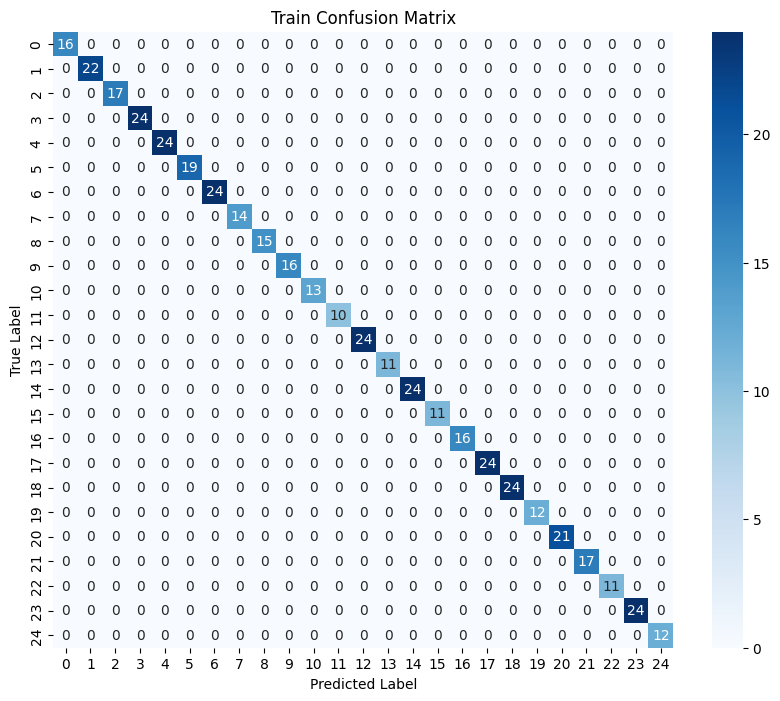

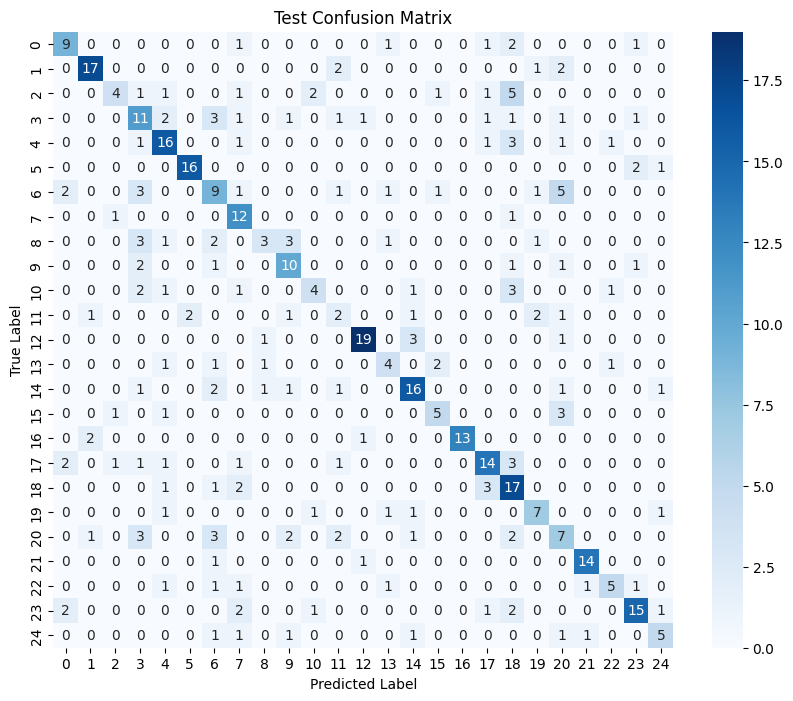

In [13]:
def custom_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    # Find all unique classes across both true labels and predictions
    all_classes = torch.unique(torch.cat([y_true, y_pred])).cpu().numpy()
    
    # Create confusion matrix with explicit labels
    cm = confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy(), 
                         labels=all_classes)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=all_classes, 
                yticklabels=all_classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

custom_confusion_matrix(y_train, train_pred, "Train Confusion Matrix")
custom_confusion_matrix(y_test, test_pred, "Test Confusion Matrix")

## Neural Networks and PCA

We are seeing how Neural Networks can be _easy_ to build and explain in generic/abstract terms (a bunch of little operators that perform weighted sums of their inputs), but in reality can be really difficult and opaque to steer.

In theory, a couple of well placed neuron layers, with the right hyperparameters, learning rate, loss function, architecture and a good amount of data, can learn to extract information like polynomial features, clusters or even PCA components. But... that's not always the case and sometimes it's not a bad idea to push/bias/encourage the network to go down a certain path.

One way to do this is to pre-process our inputs and do a bit of feature extraction ourselves.

Let's see if we can improve this face classification network by using PCA information instead of pixel data.

### Add PCA

We're going to repeat the training, but this time our data is going to be scaled and PCA'd before going into the neural network.

So, the data preparation flow should be:
- Scale data for `PCA`
- Perform `PCA`

We need one `StandardScaler()` object and one `PCA()` object.

The `train` data goes through the `fit_transform()` function of these objects, while the `test` data only goes through `transform()`.

For the `PCA`, we can aim for an explained variance of $99\%$. This should reduce the number of features significantly to allow us to experiment with our network architecture.

In [ ]:
#from data_utils import PCA, StandardScaler

In [14]:
# TODO: Scale
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# TODO: PCA
pca = PCA(n_components=320)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# TODO: Tensors
x_train_pca = Tensor(x_train_pca)
x_test_pca = Tensor(x_test_pca)

# calculate explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained variance:", explained_variance.sum())


Explained variance: 0.989994350156168


### Repeat

Re-create model, optimizer, loss function, then re-run the training loop and evaluate.

In [15]:
# TODO: Model, Optimizer and Loss Function
model = nn.Linear(x_train_pca.shape[1], pca.n_components_)
learning_rate = 5e-1
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# TODO: Training loop
epochs = 50
for epoch in range(epochs):
  for i in range(0, len(x_train_pca), 32):
    y_pred = model(x_train_pca)

    loss = loss_fn(y_pred, y_train)

    optim.zero_grad()
    loss.backward()
    optim.step()

  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")

# TODO: Evaluation
train_pred = model(x_train_pca).argmax(dim=1)
train_error = classification_error(train_pred, y_train)
print(f"train classification error: {train_error}")

test_pred = model(x_test_pca).argmax(dim=1)
test_error = classification_error(test_pred, y_test)
print(f"test classification error: {test_error}")

#display_confusion_matrix(train_pred, y_train, "Train Confusion Matrix")
#display_confusion_matrix(test_pred, y_test, "Test Confusion Matrix")

Epoch 0, Loss: 0.0009862857405096292
Epoch 10, Loss: 7.934937457321212e-06
Epoch 20, Loss: 4.562614776659757e-06
Epoch 30, Loss: 3.2562809337832732e-06
Epoch 40, Loss: 2.551262014094391e-06
train classification error: 0.0
test classification error: 0.4429223744292238


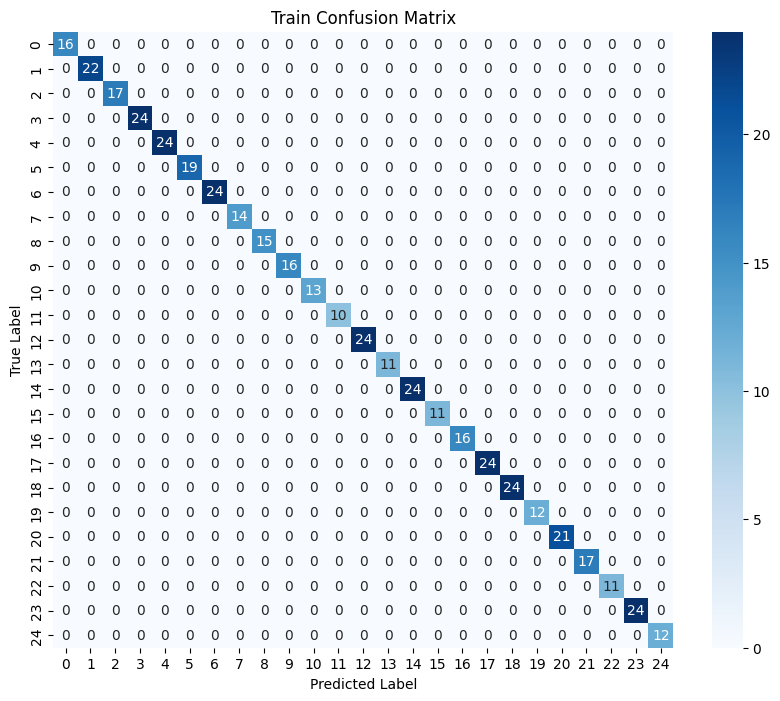

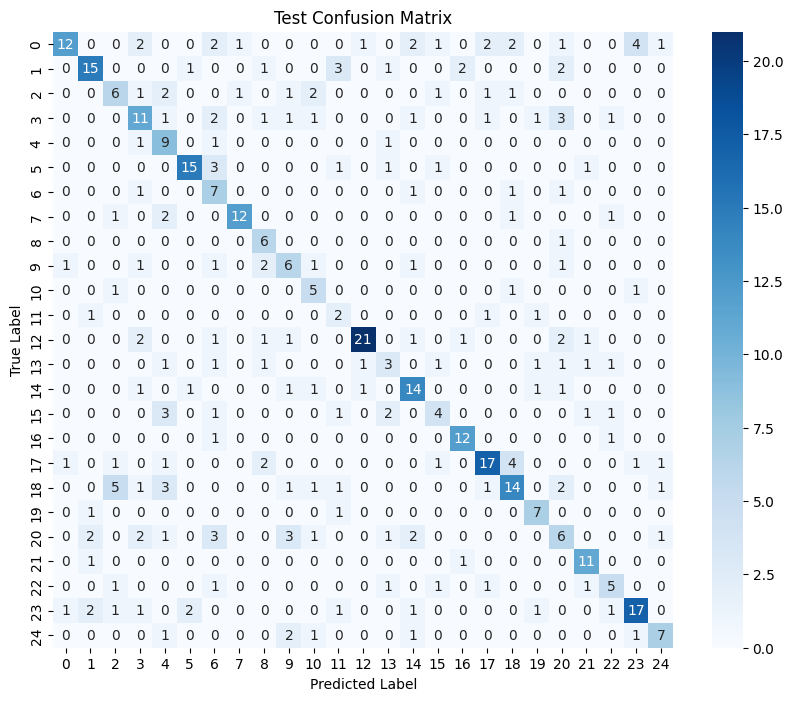

In [16]:
custom_confusion_matrix(train_pred, y_train, "Train Confusion Matrix")
custom_confusion_matrix(test_pred, y_test, "Test Confusion Matrix")

### Interpretation

<span style="color:hotpink;">
So... What happens ?<br>
How does training on the <code>PCA</code> data compare to training on the regular data ?

What else does <code>PCA</code> afford us in this case ? ...<br>
How does adding extra layers in the original network compare to adding extra layers in the <code>PCA</code> network?
</span>

<span style="color:yellow;">The error rate of training on PCA data (43.8%) is slightly higher than training on regular data (42.6%). But i noticed that model with PCA is faster since it has lesser dimenions - 320 components(to achieve 99% varience) vs 22100 features.
<br><br>
Adding extra layers to the regular model caused the error rate to spike to 92%, whereas using extra layers with pca has reduced the error rate to 25%.</span>

In [21]:
reg_model = nn.Sequential(
    nn.Linear(x_train.shape[1], 20),
    nn.Sigmoid(),                     
    nn.Linear(20, num_classes)
)

learning_rate = 5e-1
optim = torch.optim.SGD(reg_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()


epochs = 50
for epoch in range(epochs):
  for i in range(0, len(x_train), 32):

    y_pred = reg_model(x_train)

    loss = loss_fn(y_pred, y_train)

    optim.zero_grad()
    loss.backward()
    optim.step()

  if epoch % 10 == 0: # loss every 10 epochs
    print(f"Epoch {epoch}, Loss: {loss.item()}")

train_pred = reg_model(x_train).argmax(dim=1)
train_error = classification_error(train_pred, y_train)
print(f"train classification error: {train_error}")

test_pred = reg_model(x_test).argmax(dim=1)
test_error = classification_error(test_pred, y_test)
print(f"test classification error: {test_error}")    

Epoch 0, Loss: 3.164219856262207
Epoch 10, Loss: 3.175800085067749
Epoch 20, Loss: 3.1754817962646484
Epoch 30, Loss: 3.175182580947876
Epoch 40, Loss: 3.1748688220977783
train classification error: 0.9438202247191011
test classification error: 0.9452054794520548


In [18]:
pca_model = nn.Sequential(
    nn.Linear(x_train_pca.shape[1], pca.n_components_),
    nn.Sigmoid(),
    nn.Linear(pca.n_components_, num_classes)
)


learning_rate = 5e-1
optim = torch.optim.SGD(pca_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


epochs = 50
for epoch in range(epochs):
  for i in range(0, len(x_train_pca), 32):
    y_pred = pca_model(x_train_pca)

    loss = loss_fn(y_pred, y_train)

    optim.zero_grad()
    loss.backward()
    optim.step()

  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")

train_pred = pca_model(x_train_pca).argmax(dim=1)
train_error = classification_error(train_pred, y_train)
print(f"train classification error: {train_error}")

test_pred = pca_model(x_test_pca).argmax(dim=1)
test_error = classification_error(test_pred, y_test)
print(f"test classification error: {test_error}")

Epoch 0, Loss: 0.9828121662139893
Epoch 10, Loss: 0.019050531089305878
Epoch 20, Loss: 0.008595946244895458
Epoch 30, Loss: 0.005456621292978525
Epoch 40, Loss: 0.003966549411416054
train classification error: 0.0
test classification error: 0.25114155251141557
